In [52]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt 

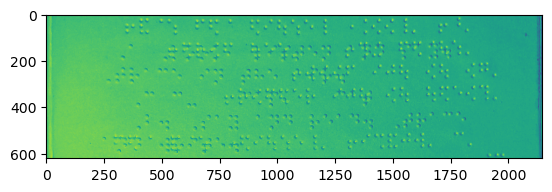

In [53]:
img = cv.imread('b9.jpg')
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

h,w = img.shape

# if w > 500:
#     new_w = 1000
#     ar = w/h
#     new_h = int(new_w/ar)

#     img = cv.resize(img,(new_w,new_h),interpolation=cv.INTER_AREA)
plt.imshow(img)

In [54]:
def thresholding(image):
    blur = cv.GaussianBlur(image, (7, 7), 0)
    thresh = cv.adaptiveThreshold(
        blur,
        255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        15,
        3
    )
    return thresh

thresh_img = thresholding(img);

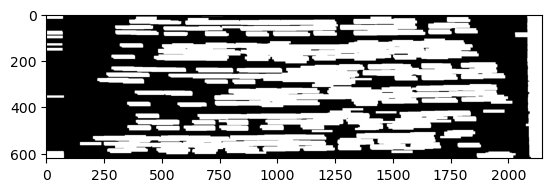

In [55]:
#dilation
kernel = np.ones((10,90), np.uint8)
dilated = cv.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [56]:
(contours, heirarchy) = cv.findContours(dilated.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv.boundingRect(ctr)[1]) # (x, y, w, h)

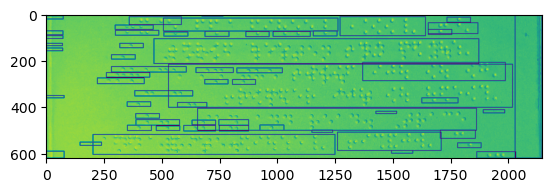

In [57]:
img2 = img.copy()
line_images = []


for ctr in sorted_contours_lines:
    
    x,y,w,h = cv.boundingRect(ctr)
    cv.rectangle(img2, (x,y), (x+w, y+h), (80, 100, 250), 2)

     # Crop each line and store it in the line_images array
    line_image = img[y:y + h, x:x + w]
    line_images.append(line_image)

    
plt.imshow(img2);

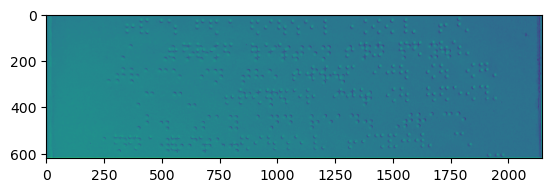

In [58]:
#dilation
kernel = np.ones((5,150), np.uint8)
dilated = cv.dilate(img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

(contours, heirarchy) = cv.findContours(dilated.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv.boundingRect(ctr)[1]) # (x, y, w, h)


img2 = img.copy()
line_images = []


for ctr in sorted_contours_lines:
    
    x,y,w,h = cv.boundingRect(ctr)
    cv.rectangle(img2, (x,y), (x+w, y+h), (255, 100, 250), 2)

     # Crop each line and store it in the line_images array
    line_image = img[y:y + h, x:x + w]
    line_images.append(line_image)
   
plt.imshow(img2);

img3 = img.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv.boundingRect(line)
    roi_line = dilated[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv.findContours(roi_line.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
        
plt.imshow(img3);